# Forest or Bird?

In [ ]:
pip install ddgs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 35.3 MB/s eta 0:00:00
  Attempting uninstall: lxml
    Found existing installation: lxml 5.4.0
    Uninstalling lxml-5.4.0:
      Successfully uninstalled lxml-5.4.0


In [ ]:
from ddgs import DDGS
from fastcore.all import *
from fastdownload import download_url
from fastai.vision.all import *
import time, json

In [ ]:
def search_images(keywords, max_images=200):
  return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')

search_images() → Get image URLs from DuckDuckGo.

download_url() → Download one of those images.

Image.open() → Load it into memory.

im.to_thumb() → Display a small preview.


In [ ]:
urls = search_images('bird photos', max_images=1)
urls[0]

'https://images.pexels.com/photos/326900/pexels-photo-326900.jpeg?cs=srgb&dl=wood-flight-bird-326900.jpg&fm=jpg'

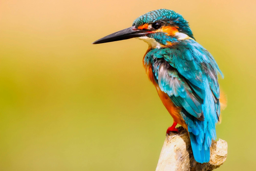

In [ ]:
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

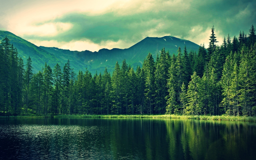

In [ ]:
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

In [ ]:
searches = 'forest','bird'
path = Path('bird_or_not')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    time.sleep(5)
    resize_images(path/o, max_size=400, dest=path/o)

In [ ]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

1

| Step | Code Part                            | Purpose                          |
| ---- | ------------------------------------ | -------------------------------- |
| 1    | `blocks=(ImageBlock, CategoryBlock)` | Define input/output types        |
| 2    | `get_items=get_image_files`          | Find all image files             |
| 3    | `splitter=RandomSplitter(...)`       | Split into train/valid sets      |
| 4    | `get_y=parent_label`                 | Use folder name as label         |
| 5    | `item_tfms=[Resize(192)]`            | Resize all images                |
| 6    | `.dataloaders(path, bs=32)`          | Build dataloaders                |
| 7    | `dls.show_batch(max_n=6)`            | Visualize sample images + labels |


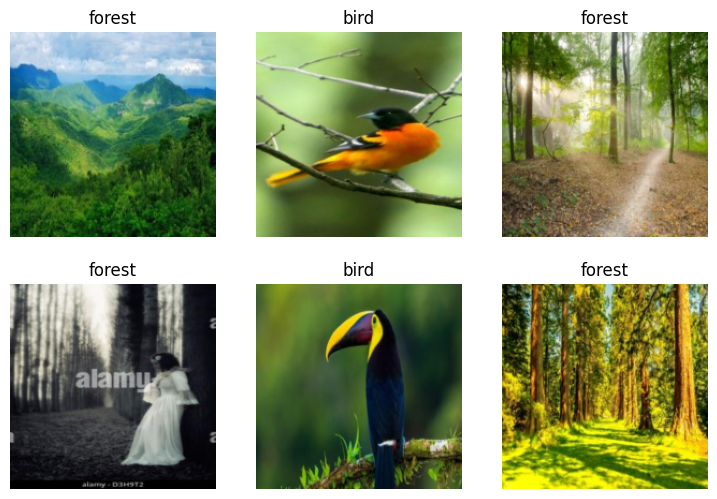

In [ ]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

| Line                                                | Function     | What It Does                                                      |
| --------------------------------------------------- | ------------ | ----------------------------------------------------------------- |
| `vision_learner(dls, resnet18, metrics=error_rate)` | Create model | Loads pretrained ResNet18, ready for your dataset                 |
| `learn.fine_tune(3)`                                | Train model  | Fine-tunes the model for 3 epochs in 2 phases (frozen + unfrozen) |


In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 115MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.010072,0.863636,0.270270,00:17


epoch,train_loss,valid_loss,error_rate,time
0,0.307710,0.147991,0.054054,00:24
1,0.198348,0.057271,0.027027,00:24
2,0.140060,0.039844,0.000000,00:26


| Step | Code                          | Meaning                                  |
| ---- | ----------------------------- | ---------------------------------------- |
| 1    | `PILImage.create('bird.jpg')` | Load the image for prediction            |
| 2    | `learn.predict(...)`          | Use your trained model to predict        |
| 3    | `is_bird`                     | The predicted label ("bird" or "forest") |
| 4    | `probs`                       | Probability of each class                |
| 5    | `print(...)`                  | Nicely display the result                |


<Axes: title={'center': 'Prediction: bird (0.9999 bird probability)'}>

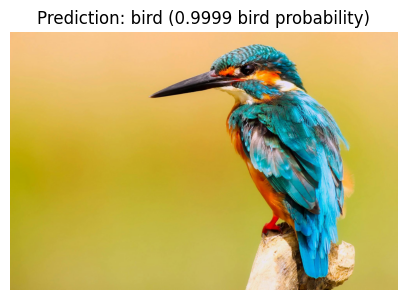

In [ ]:
img = PILImage.create('bird.jpg')
is_bird, _, probs = learn.predict(img)
img.show(title=f"Prediction: {is_bird} ({probs[0]:.4f} bird probability)")

# Cat or Dog?

| Code                    | Purpose                                  |
| ----------------------- | ---------------------------------------- |
| `URLs.PETS`             | URL to the Oxford-IIIT Pet dataset       |
| `untar_data(URLs.PETS)` | Downloads and extracts the dataset       |
| `/'images'`             | Accesses the folder with the image files |


In [ ]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)/'images'

In this dataset:

Cat breeds → filenames start with a capital letter (e.g., Abyssinian, Bombay)

Dog breeds → filenames start with a lowercase letter (e.g., beagle, pug)

| Code Part                              | Purpose                                             |
| -------------------------------------- | --------------------------------------------------- |
| `def is_cat(x): return x[0].isupper()` | Function that labels images (cats = uppercase name) |
| `get_image_files(path)`                | Collect all image file paths                        |
| `valid_pct=0.2`                        | 80/20 train-validation split                        |
| `label_func=is_cat`                    | Assigns “cat” or “dog” label based on filename      |
| `item_tfms=Resize(224)`                | Resizes all images to a uniform shape               |
| `ImageDataLoaders.from_name_func(...)` | Creates the full DataLoaders object                 |


In [ ]:
def is_cat(x): return x[0].isupper()
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=42,
    label_func=is_cat, item_tfms=Resize(224))

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 148MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.147651,0.024666,0.008119,30:47


epoch,train_loss,valid_loss,error_rate,time
0,0.064863,0.014970,0.004060,45:18


In [ ]:
uploader = SimpleNamespace(data = ['/content/drive/MyDrive/Fastai Pytorch/images/cat.jpg'])

In [ ]:
img = PILImage.create(uploader.data[0])
is_cat,_,probs = learn.predict(img)
print(f"Is this a cat?: {is_cat}.")
print(f"Probability it's a cat: {probs[1].item():.6f}")

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Fastai Pytorch/images/cat.jpg'

In [ ]:
img = PILImage.create('/content/drive/MyDrive/Fastai Pytorch/images/cat.jpg')
is_cat, _, probs = learn.predict(img)
img.show(title=f"Prediction: {is_cat} ({probs[0]:.6f} cat probability)")

In [ ]:
uploader = SimpleNamespace(data = ['/content/drive/MyDrive/Fastai Pytorch/images/dog.jpg'])

In [ ]:
img = PILImage.create(uploader.data[0])
is_cat,_,probs = learn.predict(img)
print(f"Is this a cat?: {is_cat}.")
print(f"Probability it's a cat: {probs[1].item():.6f}")

In [ ]:
img = PILImage.create('/content/drive/MyDrive/Fastai Pytorch/images/dog.jpg')
is_cat, _, probs = learn.predict(img)
img.show(title=f"Prediction: {is_cat} ({probs[0]:.6f} bird probability)")

# Camvid Dataset - Self Driving Cars

| Part                                      | Meaning                                                |
| ----------------------------------------- | ------------------------------------------------------ |
| `SegmentationDataLoaders`                 | FastAI class for semantic segmentation datasets        |
| `path`                                    | Base directory for dataset                             |
| `bs=8`                                    | Batch size = 8 images per batch                        |
| `fnames = get_image_files(path/"images")` | Collects all image filenames from `images/` folder     |
| `label_func = ...`                        | Function to find the corresponding mask for each image |
| `codes = np.loadtxt(...)`                 | Loads all class labels (categories) from `codes.txt`   |


o = path of an input image, e.g.
/images/0006R0_f00420.png

o.stem = filename without extension → "0006R0_f00420"

o.suffix = extension → ".png"

U-Net architecture is specialized for pixel-wise segmentation.

In [ ]:
path = untar_data(URLs.CAMVID_TINY)
dls = SegmentationDataLoaders.from_label_func(
    path, bs=8, fnames = get_image_files(path/"images"),
    label_func = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',
    codes = np.loadtxt(path/'codes.txt', dtype=str)
)

learn = unet_learner(dls, resnet34)
learn.fine_tune(8)

In [ ]:
learn.show_results(max_n=6, figsize=(7,8))

# IMDB Dataset - Sentiment Analysis

In [ ]:
from fastai.text.all import *

dls = TextDataLoaders.from_folder(untar_data(URLs.IMDB), valid='test')
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)
learn.fine_tune(4, 1e-2)

In [ ]:
learn.predict("I really liked that movie!")

# Tabular Dataset

In [ ]:
from fastai.tabular.all import *
path = untar_data(URLs.ADULT_SAMPLE)

dls = TabularDataLoaders.from_csv(path/'adult.csv', path=path, y_names="salary",
    cat_names = ['workclass', 'education', 'marital-status', 'occupation',
                 'relationship', 'race'],
    cont_names = ['age', 'fnlwgt', 'education-num'],
    procs = [Categorify, FillMissing, Normalize])

learn = tabular_learner(dls, metrics=accuracy)

In [ ]:
learn.fit_one_cycle(3)

# MovieLens Dataset - Recommendation System

In [ ]:
from fastai.collab import *
path = untar_data(URLs.ML_SAMPLE)
dls = CollabDataLoaders.from_csv(path/'ratings.csv')
learn = collab_learner(dls, y_range=(0.5,5.5))
learn.fine_tune(10)

In [ ]:
learn.show_results()